In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False
from tqdm import tqdm

In [2]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [3]:
df.date_time = pd.to_datetime(df.date_time)

In [4]:
df_1 = df[df['num']==1]

In [5]:
df_1

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,1,2020-08-24 19:00:00,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0
2036,1,2020-08-24 20:00:00,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0
2037,1,2020-08-24 21:00:00,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0
2038,1,2020-08-24 22:00:00,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0


In [6]:
df_1 = df_1.set_index(['date_time'])

<Axes: xlabel='date_time'>

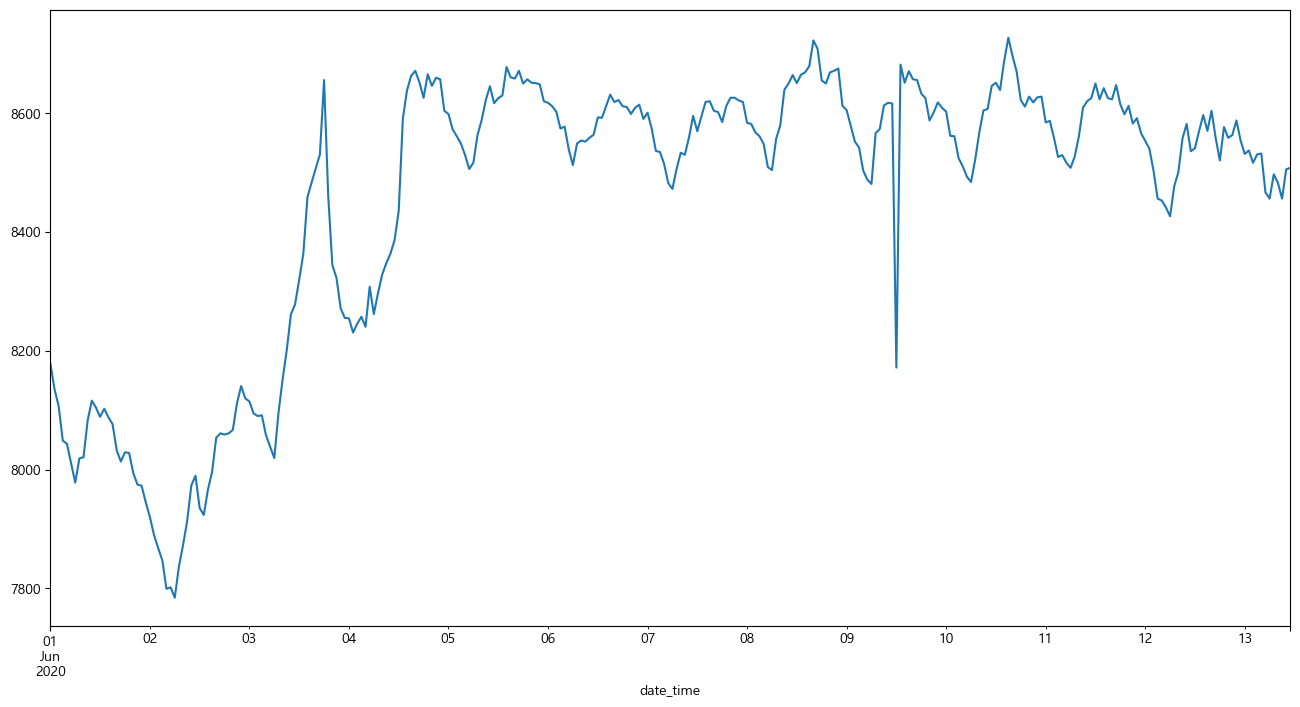

In [7]:
df_1.iloc[:300,1].plot(figsize=(16,8))

<Axes: xlabel='date_time'>

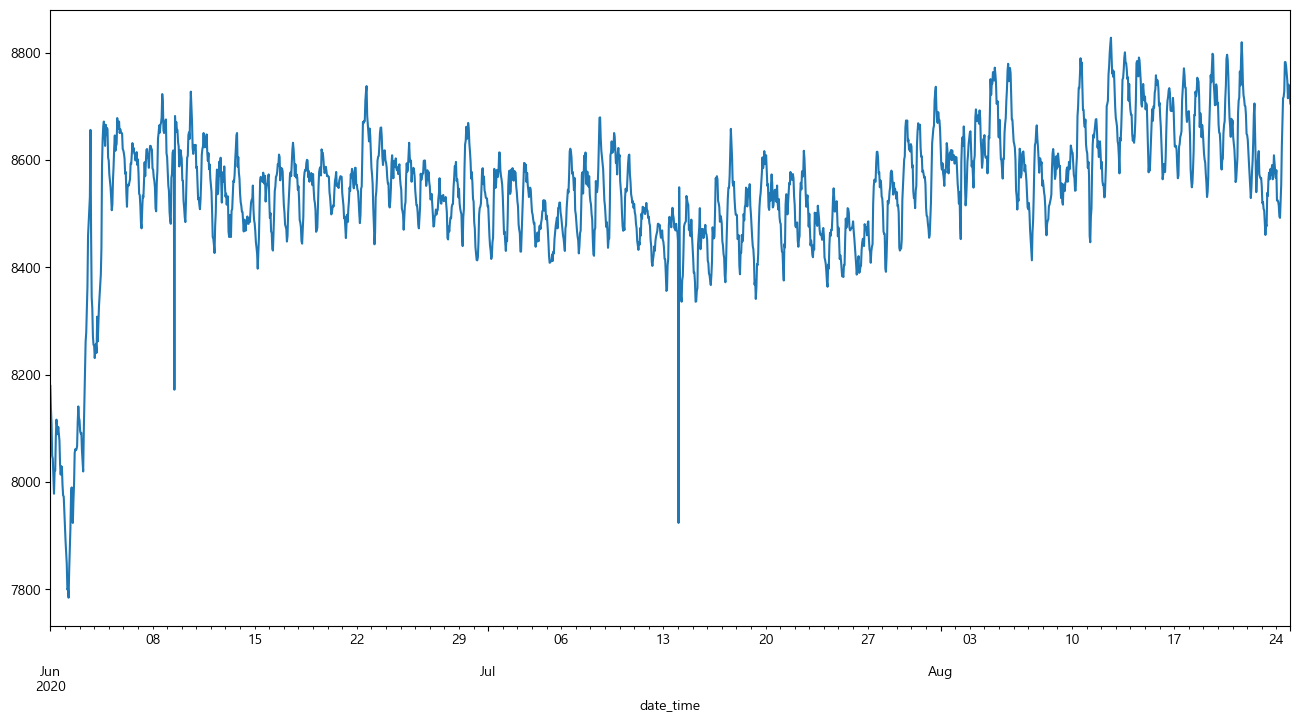

In [8]:
df_1['전력사용량(kWh)'].plot(figsize=(16,8))

In [9]:
group = df.groupby(['num','date_time']).mean()

<Axes: xlabel='num', ylabel='전력사용량(kWh)'>

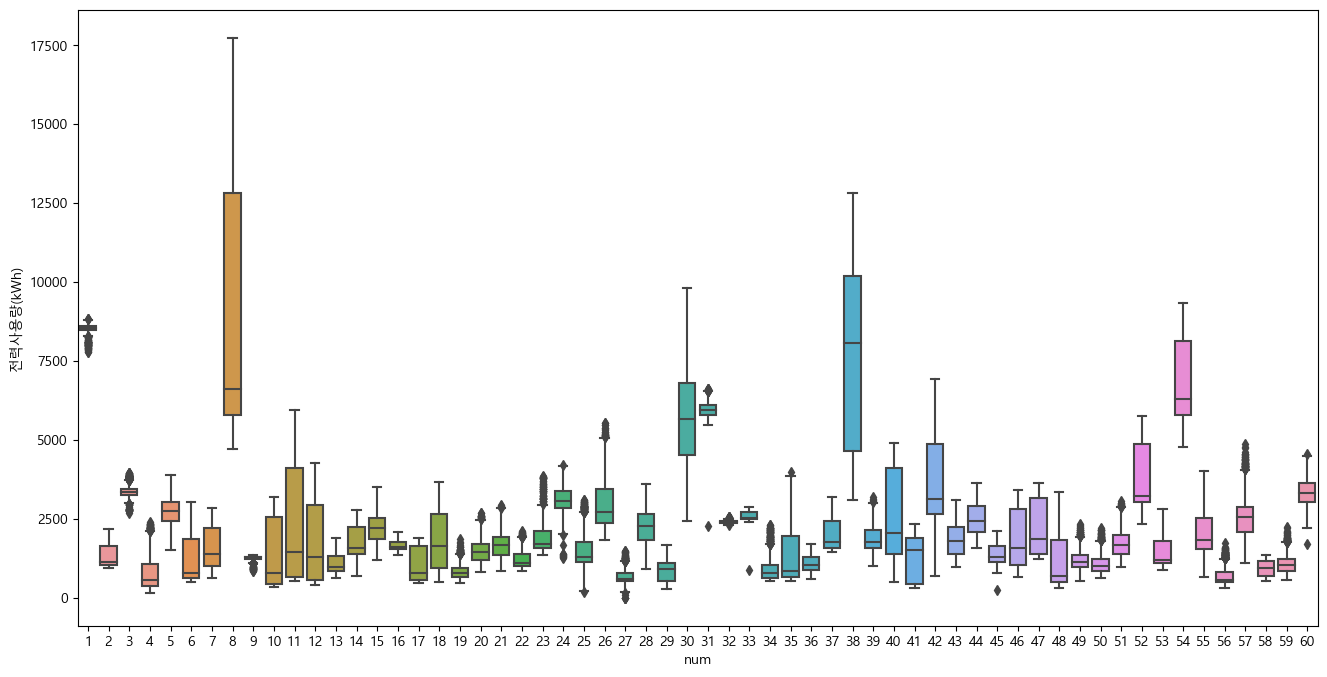

In [10]:
plt.figure(figsize=(16,8))
sns.boxplot(x='num', y='전력사용량(kWh)', data=df)

<Axes: xlabel='date_time', ylabel='전력사용량(kWh)'>

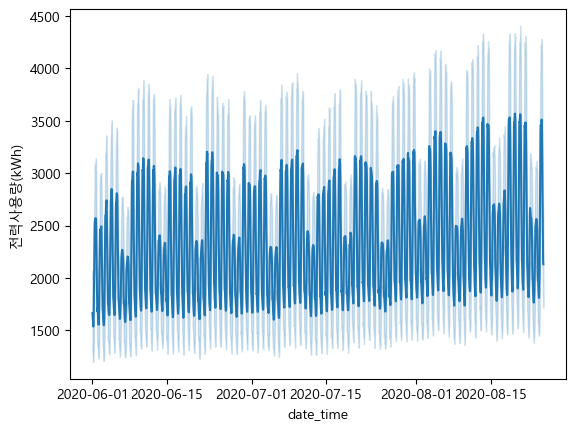

In [11]:
sns.lineplot(x='date_time', y='전력사용량(kWh)', data = df.groupby(['num','date_time']).mean())

In [12]:
eda_df = df.copy()

In [13]:
eda_df['month'] = 0
eda_df['hour'] = 0
eda_df['year'] = 0
eda_df['day'] = 0
eda_df['요일'] = 0

In [14]:
import datetime

In [15]:
days = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

In [16]:
for i in tqdm(range(len(eda_df))):
    eda_df['month'][i] = eda_df.date_time[i].month
    eda_df['hour'][i] = eda_df.date_time[i].hour
    eda_df['year'][i] = eda_df.date_time[i].year
    eda_df['day'][i] = eda_df.date_time[i].day
    eda_df['요일'][i] = days[eda_df.date_time[i].weekday()]

100%|██████████| 122400/122400 [01:10<00:00, 1748.21it/s]


In [17]:
input = eda_df.drop(['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','month'], axis=1)

In [18]:
mean = pd.DataFrame(input.groupby(['num','요일','hour']).mean()['전력사용량(kWh)'])

In [19]:
std = pd.DataFrame(input.groupby(['num','요일','hour']).std()['전력사용량(kWh)'])

In [20]:
total_df = pd.merge(mean, std, how='inner', left_on = ['num','요일','hour'], right_on=['num','요일','hour'])

In [21]:
total_df.reset_index(inplace=True)

In [22]:
total_df.columns = ['num' ,'요일', 'hour', 'mean', 'std']

for i in range(1,61):
    sns.boxplot(x = '요일', y = '전력사용량(kWh)', data = eda_df[eda_df['num'] == i])
    plt.title('{} 기업 요일별 전력사용량'.format(i))
    plt.savefig('./energy_plot/요일별_전력사용량_{}.png'.format(i))
    plt.cla()
    for j in days:
        sns.boxplot(x = 'hour', y = '전력사용량(kWh)', data = eda_df[(eda_df['num'] == i) & (eda_df['요일'] == j)])
        plt.title('{} 기업 {} 요일 시간별 전력사용량'.format(i,j))
        plt.savefig('./energy_plot/{} 기업 {} 시간별 전력사용량.png'.format(i,j))
        plt.cla()

In [23]:
# 예측 모형
def predict(data, mean, std):
    # 각 시간마다 평균값과 분산을 다르게 설정
    predicted_values = []
    for i in range(len(data)):
        # 각 시간마다 평균값과 분산 설정
        mu_i = mean[i % 12]
        std_i = std[i % 12]

        # 예측값 계산
        y_i = np.random.normal(mu_i, std_i)
        predicted_values.append(y_i)

    return predicted_values

# 예측값 출력
#predicted_values = predict(data)

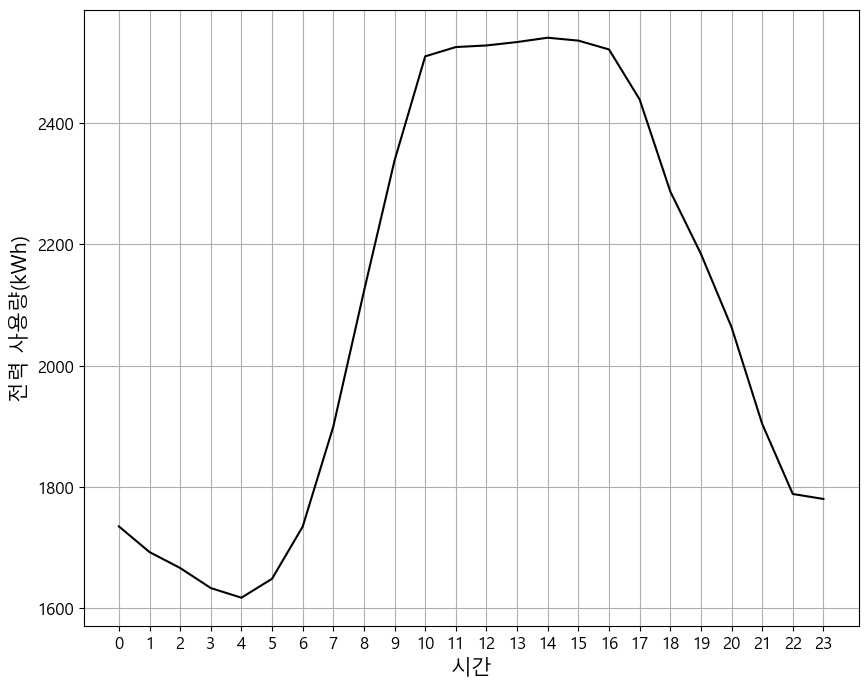

In [24]:
qq = eda_df[eda_df['태양광보유'] == 0].groupby(['hour']).mean()['전력사용량(kWh)']
plt.figure(figsize=(10,8))
plt.plot(qq, color = 'k')
plt.grid(True)
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0,24,1) , fontsize = 12)
plt.xlabel('시간', fontsize = 15)
plt.ylabel('전력 사용량(kWh)', fontsize = 15)
plt.show()

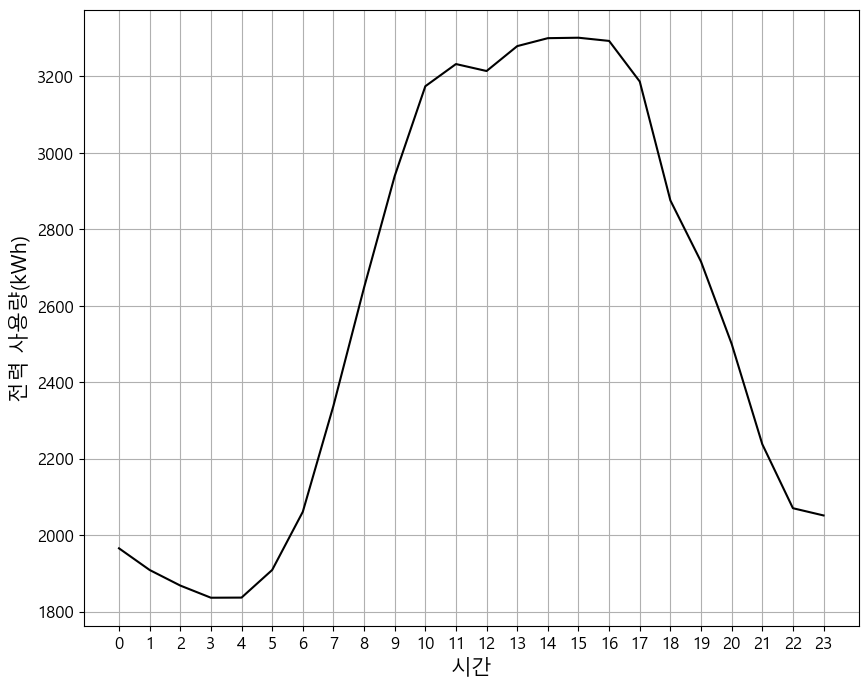

In [25]:
eda_df[eda_df['태양광보유'] == 1].groupby(['hour']).mean()['전력사용량(kWh)'].plot(figsize=(10,8), color = 'k')
plt.grid(True)
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0,24,1) , fontsize = 12)
plt.xlabel('시간', fontsize = 15)
plt.ylabel('전력 사용량(kWh)', fontsize = 15)
plt.show()

<Axes: xlabel='hour'>

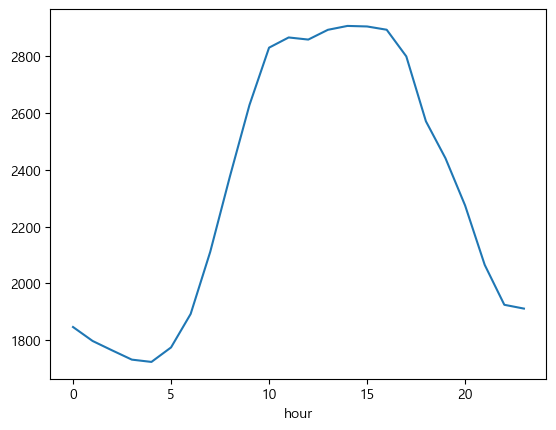

In [26]:
eda_df.groupby(['hour']).mean()['전력사용량(kWh)'].plot()

In [27]:
import numpy as np
import scipy.stats as stats

# 기존 데이터
mu = [10, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 25,
      26, 25, 24, 23, 22, 21, 20, 19, 18, 16, 14, 12]
sigma = [1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1]

# 새로운 하루의 데이터
daily_data = [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
              40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29]

# 초기 사전확률
prior = np.array([1/(len(daily_data)) for i in range(len(daily_data))])

# 베이지안 업데이트 함수
def bayesian_update(prior, likelihood):
    posterior = prior * likelihood
    posterior /= np.sum(posterior)
    return posterior

# 추론 결과
posterior_list = []

# 시간 단위로 업데이트
for i, data in enumerate(daily_data):
    # 기존 데이터의 평균과 표준편차
    mu_old = np.mean(mu[:i])
    sigma_old = np.std(mu[:i])

    # 우도
    likelihood = stats.norm(mu_old, sigma_old).pdf(data)

    # 베이지안 업데이트
    posterior = bayesian_update(prior, likelihood)
    posterior_list.append(posterior)

    # 사전확률 업데이트
    prior = posterior

# 평균값 계산
mean_posterior = np.mean(posterior_list, axis=0)

print(f"새로운 하루에 대한 사후확률의 평균값: {mean_posterior}")


새로운 하루에 대한 사후확률의 평균값: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]


In [28]:
# 가정: 시간대별로 정규분포의 평균 및 표준편차가 다름
hourly_means = np.random.normal(loc=0, scale=10, size=24)
hourly_std_devs = np.random.uniform(low=1, high=5, size=24)


In [29]:
def update(hour, new_data, alpha=0.1):
    """
    hour: 현재 시간대 (0-23)
    new_data: 새로운 데이터
    alpha: 업데이트 비율
    """
    old_mean = hourly_means[hour]
    old_std_dev = hourly_std_devs[hour]

    # 평균 업데이트
    new_mean = old_mean * (1 - alpha) + new_data * alpha

    # 표준편차 업데이트
    new_std_dev = np.sqrt((1 - alpha) * (old_std_dev ** 2) + alpha * ((new_data - old_mean) ** 2))

    # 값 업데이트
    hourly_means[hour] = new_mean
    hourly_std_devs[hour] = new_std_dev

    return new_mean


In [30]:
def predict(hour, new_data):
    updated_mean = update(hour, new_data)
    return stats.norm(updated_mean, hourly_std_devs[hour]).pdf(new_data)


In [31]:
# 샘플 데이터 생성 함수
def generate_sample_data(hour, n_samples=10):
    np.random.seed(42)
    return np.random.normal(loc=hourly_means[hour], scale=hourly_std_devs[hour], size=n_samples)

# 각 시간대별로 샘플 데이터 생성
sample_data_by_hour = {hour: generate_sample_data(hour) for hour in range(24)}

# 초기 평균과 표준편차 출력
# print("Initial means:", hourly_means)
# print("Initial std devs:", hourly_std_devs)

# 각 시간대별로 새로운 데이터로 평균과 표준편차 업데이트 및 사후 확률 출력
for hour, sample_data in sample_data_by_hour.items():
    print(f"\nHour {hour}:")
    for i, data in enumerate(sample_data):
        posterior_probability = predict(hour, data)
        print(f"  Data {i+1}: {data}, Posterior probability: {posterior_probability}")

# 업데이트된 평균과 표준편차 출력
# print("\nUpdated means:", hourly_means)
# print("Updated std devs:", hourly_std_devs)



Hour 0:
  Data 1: -0.7530520201570581, Posterior probability: 0.07583265145218601
  Data 2: -3.8711326478994823, Posterior probability: 0.08736016128563164
  Data 3: -0.011687801683069488, Posterior probability: 0.07520154462051157
  Data 4: 4.286701835475405, Posterior probability: 0.034346306318221456
  Data 5: -4.341998801996165, Posterior probability: 0.07946143231388307
  Data 6: -4.341918182026767, Posterior probability: 0.08385603587769314
  Data 7: 4.5625899309266735, Posterior probability: 0.03410470589174856
  Data 8: 0.5763294390697866, Posterior probability: 0.07943918050760738
  Data 9: -5.497549642385634, Posterior probability: 0.06504242780958684
  Data 10: -0.5279244078403043, Posterior probability: 0.08995954569801956

Hour 1:
  Data 1: 6.388035414843455, Posterior probability: 0.1184591907236731
  Data 2: 4.391969765577191, Posterior probability: 0.13646646674237004
  Data 3: 6.862625980887438, Posterior probability: 0.11747333037053129
  Data 4: 9.61427641146215, Po

In [32]:
sample_data_by_hour

{0: array([-0.75305202, -3.87113265, -0.0116878 ,  4.28670184, -4.3419988 ,
        -4.34191818,  4.56258993,  0.57632944, -5.49754964, -0.52792441]),
 1: array([6.38803541, 4.39196977, 6.86262598, 9.61427641, 4.09054082,
        4.09059243, 9.79088851, 7.23905018, 3.35080519, 6.53215276]),
 2: array([ 2.21402686, -0.03430992,  2.74859817,  5.84801371, -0.37383472,
        -0.37377659,  6.04694678,  3.17259644, -1.20706124,  2.37635836]),
 3: array([20.364443  , 17.90414525, 20.94941079, 24.34102237, 17.5326119 ,
        17.53267551, 24.55870977, 21.41338131, 16.62083331, 20.54207823]),
 4: array([5.89649491, 3.609009  , 6.44037443, 9.59375848, 3.26357224,
        3.26363138, 9.79615547, 6.87175557, 2.41583718, 6.061653  ]),
 5: array([3.78744912, 2.24898995, 4.15323779, 6.27406074, 2.01666486,
        2.01670464, 6.41018377, 4.44336516, 1.44651675, 3.89852695]),
 6: array([ -9.64694218, -11.23776096,  -9.26870433,  -7.07570173,
        -11.47799295, -11.47795182,  -6.93494592,  -8.968

In [33]:
sample_data_by_hour

{0: array([-0.75305202, -3.87113265, -0.0116878 ,  4.28670184, -4.3419988 ,
        -4.34191818,  4.56258993,  0.57632944, -5.49754964, -0.52792441]),
 1: array([6.38803541, 4.39196977, 6.86262598, 9.61427641, 4.09054082,
        4.09059243, 9.79088851, 7.23905018, 3.35080519, 6.53215276]),
 2: array([ 2.21402686, -0.03430992,  2.74859817,  5.84801371, -0.37383472,
        -0.37377659,  6.04694678,  3.17259644, -1.20706124,  2.37635836]),
 3: array([20.364443  , 17.90414525, 20.94941079, 24.34102237, 17.5326119 ,
        17.53267551, 24.55870977, 21.41338131, 16.62083331, 20.54207823]),
 4: array([5.89649491, 3.609009  , 6.44037443, 9.59375848, 3.26357224,
        3.26363138, 9.79615547, 6.87175557, 2.41583718, 6.061653  ]),
 5: array([3.78744912, 2.24898995, 4.15323779, 6.27406074, 2.01666486,
        2.01670464, 6.41018377, 4.44336516, 1.44651675, 3.89852695]),
 6: array([ -9.64694218, -11.23776096,  -9.26870433,  -7.07570173,
        -11.47799295, -11.47795182,  -6.93494592,  -8.968

In [34]:
class HourlyDataUpdater:
    def __init__(self, hourly_means, hourly_std_devs, alpha=0.1):
        self.hourly_means = hourly_means
        self.hourly_std_devs = hourly_std_devs
        self.alpha = alpha

    def update(self, hour, new_data):
        old_mean = self.hourly_means[hour]
        old_std_dev = self.hourly_std_devs[hour]

        # 평균 업데이트
        new_mean = old_mean * (1 - self.alpha) + new_data * self.alpha

        # 표준편차 업데이트
        new_std_dev = np.sqrt((1 - self.alpha) * (old_std_dev ** 2) + self.alpha * ((new_data - old_mean) ** 2))

        # 값 업데이트
        self.hourly_means[hour] = new_mean
        self.hourly_std_devs[hour] = new_std_dev

        return new_mean

    def predict(self, hour, new_data):
        updated_mean = self.update(hour, new_data)
        return stats.norm(updated_mean, self.hourly_std_devs[hour]).pdf(new_data)

In [35]:
total_df[total_df['num']==1]

,num,요일,hour,mean,std
0,1,금요일,0,8560.674,72.503094
1,1,금요일,1,8539.398,73.388010
2,1,금요일,2,8524.980,75.023042
3,1,금요일,3,8507.646,72.510991
4,1,금요일,4,8493.390,69.498200
...,...,...,...,...,...
163,1,화요일,19,8553.978,169.840621
164,1,화요일,20,8539.614,161.915728
165,1,화요일,21,8544.150,149.660190
166,1,화요일,22,8554.626,143.949497


In [36]:
total_df[total_df['num']==1].drop(['num','요일'],axis=1)

,hour,mean,std
0,0,8560.674,72.503094
1,1,8539.398,73.388010
2,2,8524.980,75.023042
3,3,8507.646,72.510991
4,4,8493.390,69.498200
...,...,...,...
163,19,8553.978,169.840621
164,20,8539.614,161.915728
165,21,8544.150,149.660190
166,22,8554.626,143.949497


In [37]:
qq

hour
0     1735.225589
1     1692.903784
2     1666.609425
3     1633.573938
4     1617.613663
5     1648.865081
6     1734.799139
7     1899.729083
8     2122.854550
9     2338.618454
10    2510.151369
11    2525.470123
12    2528.122890
13    2533.748912
14    2540.869591
15    2536.093144
16    2521.542452
17    2439.140675
18    2287.514923
19    2184.609139
20    2063.785593
21    1904.353268
22    1788.636320
23    1780.426212
Name: 전력사용량(kWh), dtype: float64

In [38]:
mean = eda_df[eda_df['태양광보유'] == 0].groupby(['hour']).mean()['전력사용량(kWh)']
std = eda_df[eda_df['태양광보유'] == 0].groupby(['hour']).std()['전력사용량(kWh)']

In [39]:
import datetime

In [40]:
df_1.index[0].date()

datetime.date(2020, 6, 1)

In [41]:
def get_weekday_indices(index):
    datetime_index = pd.DatetimeIndex(index)
    weekday_indices = datetime_index[datetime_index.weekday < 5]
    return weekday_indices

In [42]:
weekday = get_weekday_indices(df_1.index)

In [43]:
input_1 = df_1.loc[weekday]

In [47]:
hourly_means = mean 
hourly_std_devs = std
total_means = []

for i in range(40):
    new_data = input_1.iloc[24*i : 24*(i+1), 1]

    updater = HourlyDataUpdater(hourly_means, hourly_std_devs, alpha=0.3)

    updated_means = []
    for hour, data in enumerate(new_data):
        updated_mean = updater.update(hour, data)
        updated_means.append(updated_mean)
        
    total_means.append(updated_means)

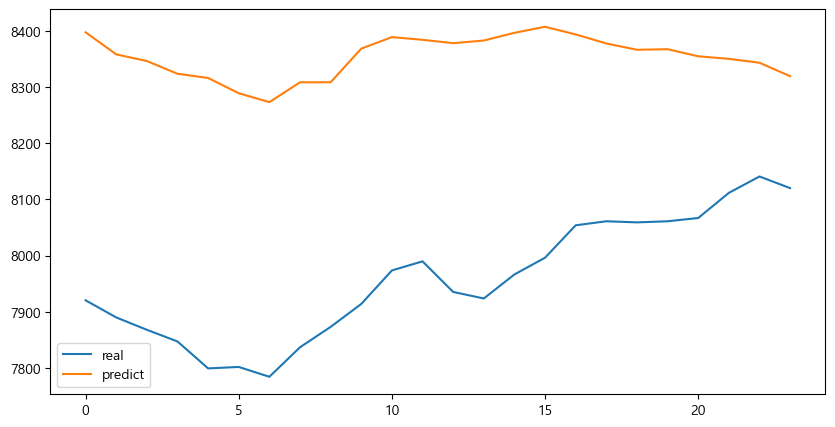

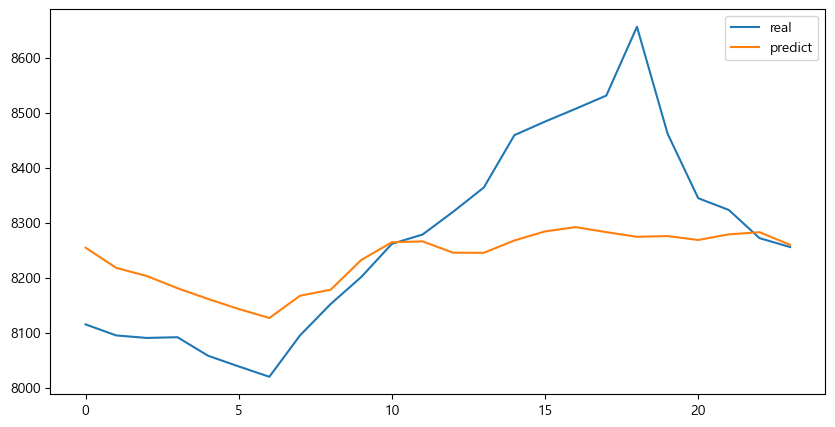

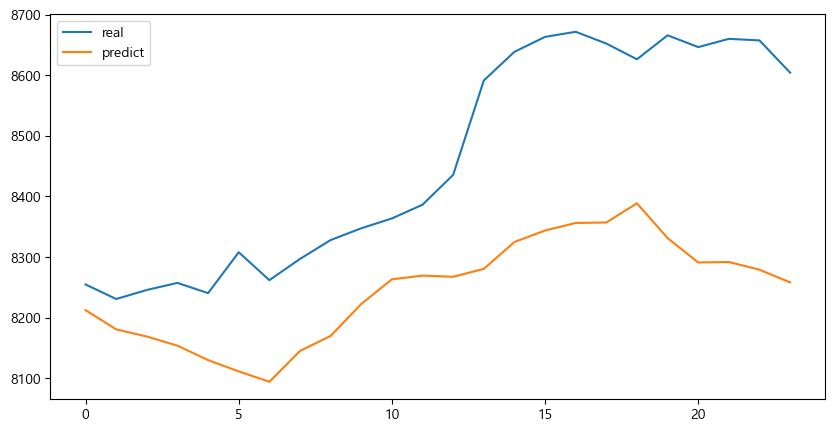

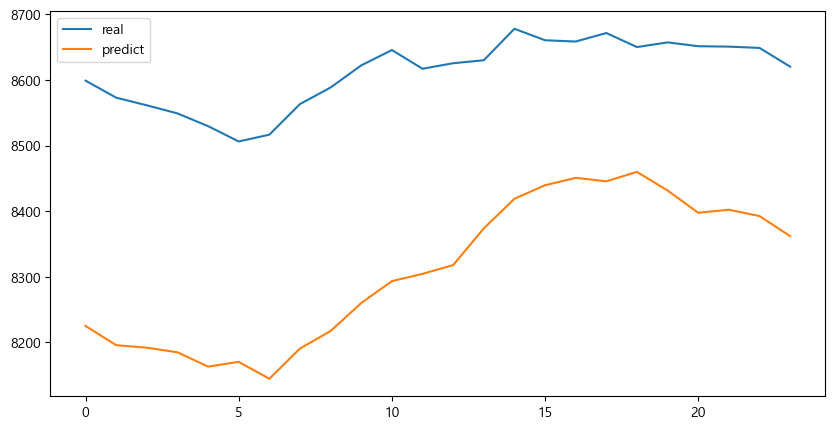

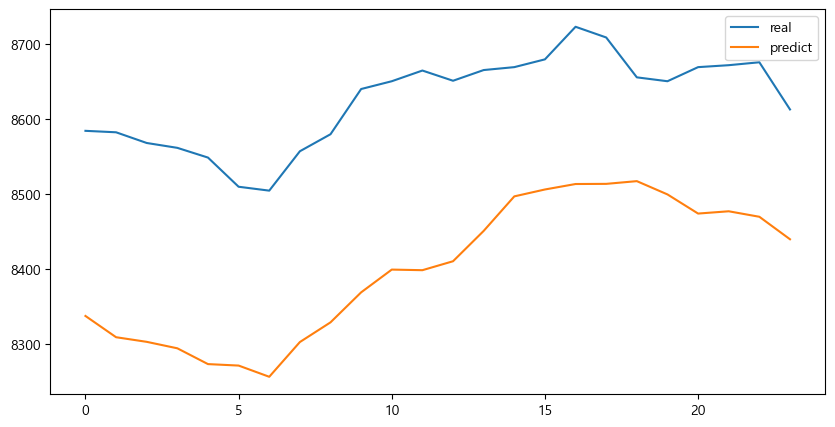

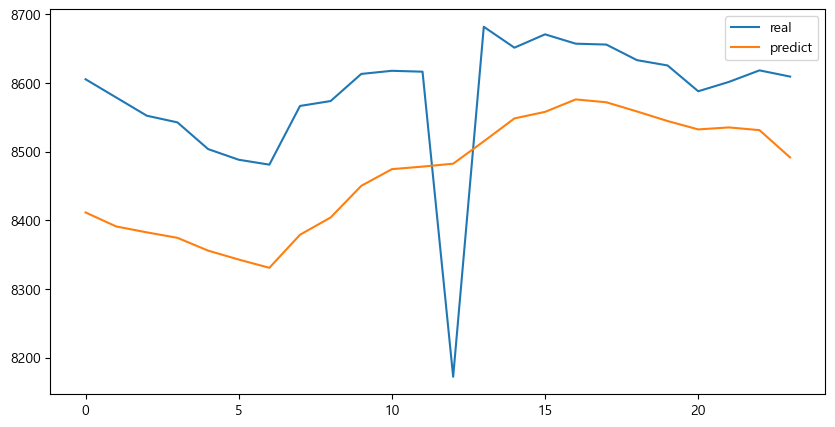

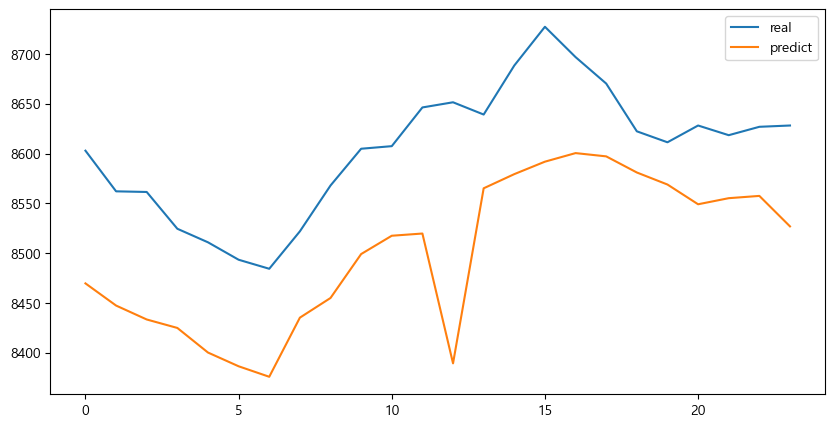

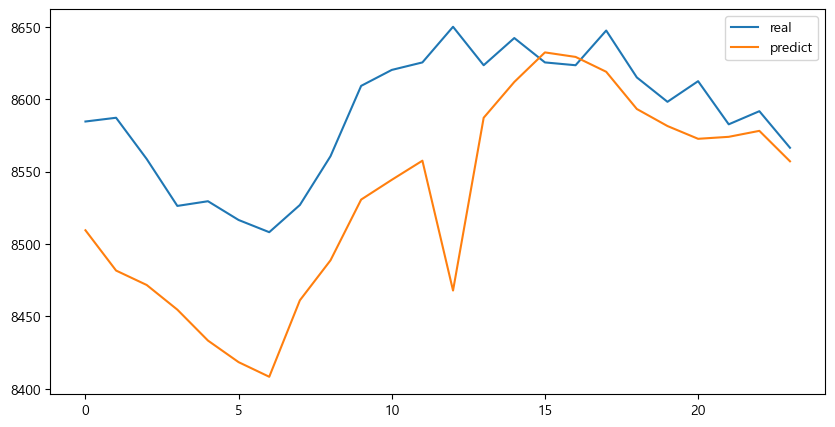

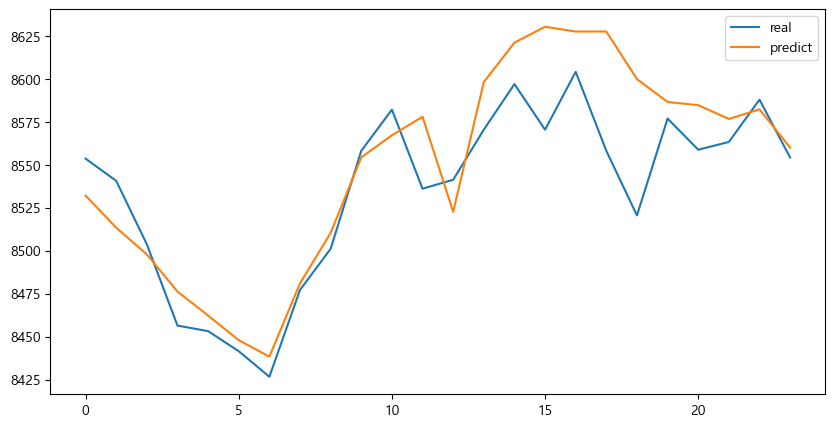

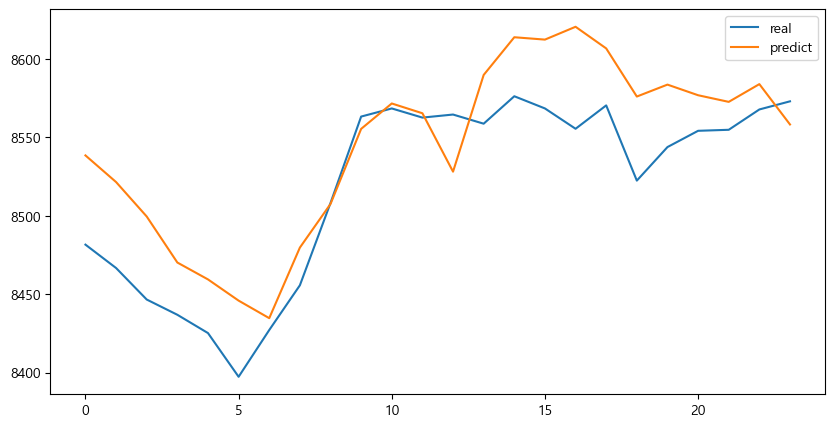

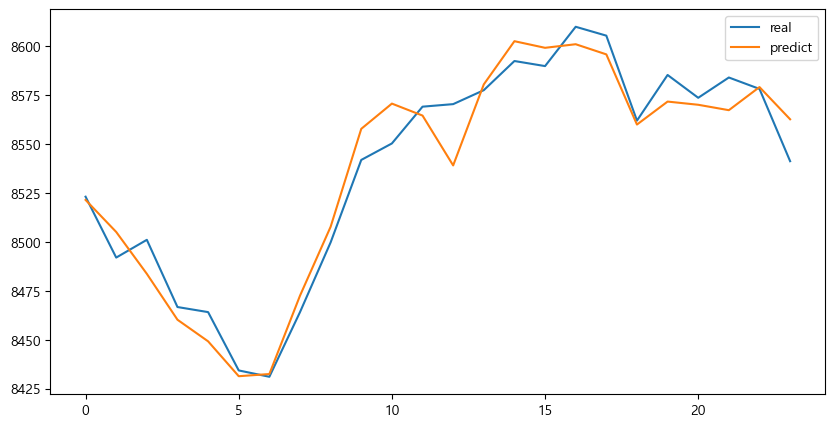

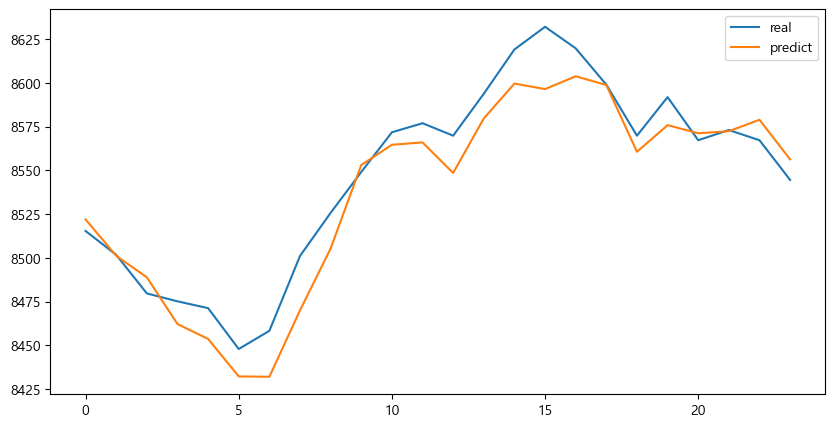

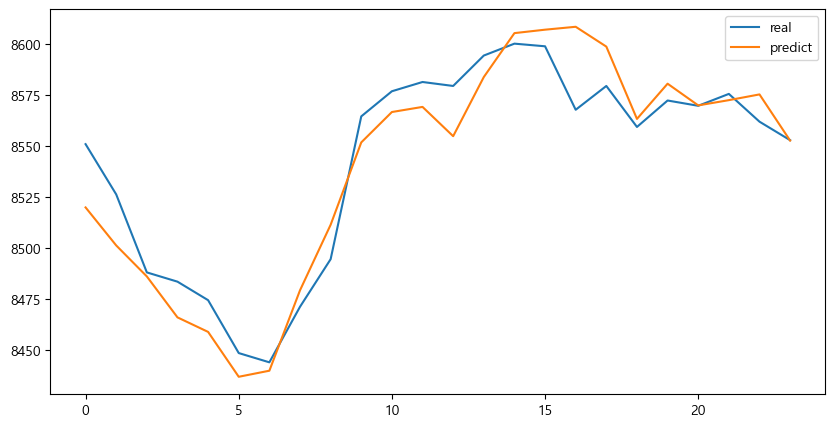

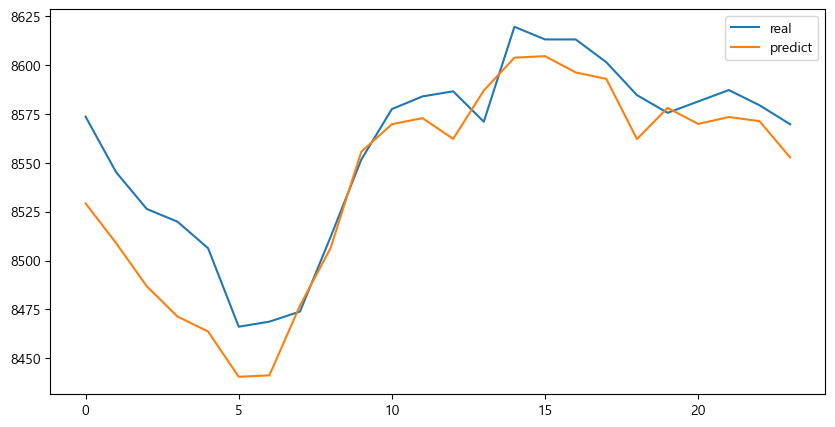

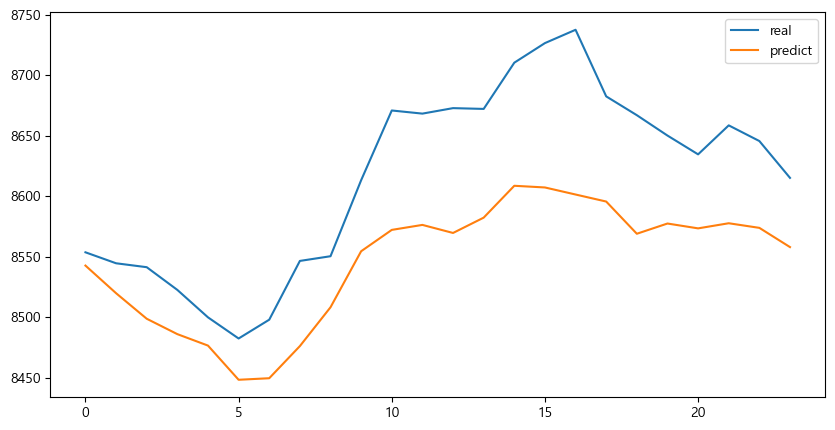

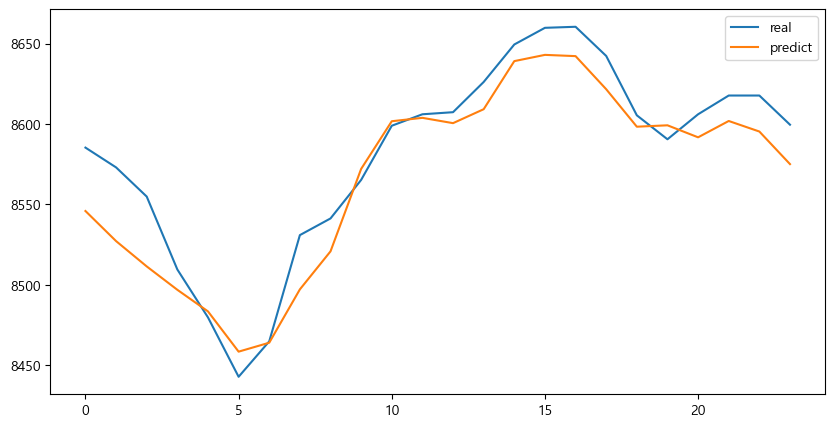

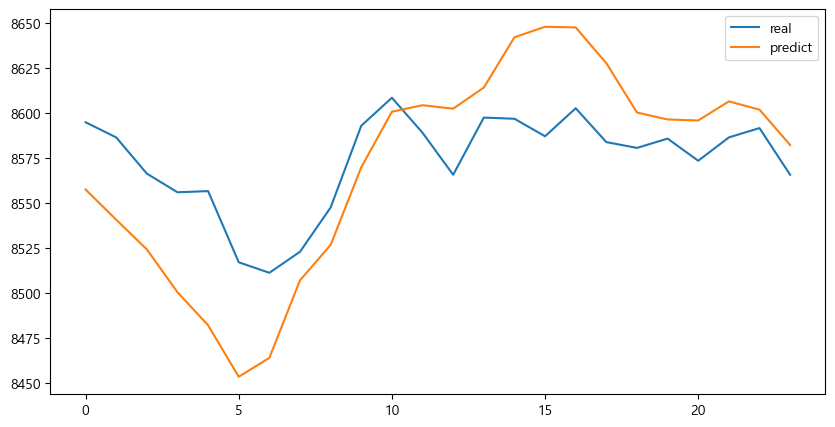

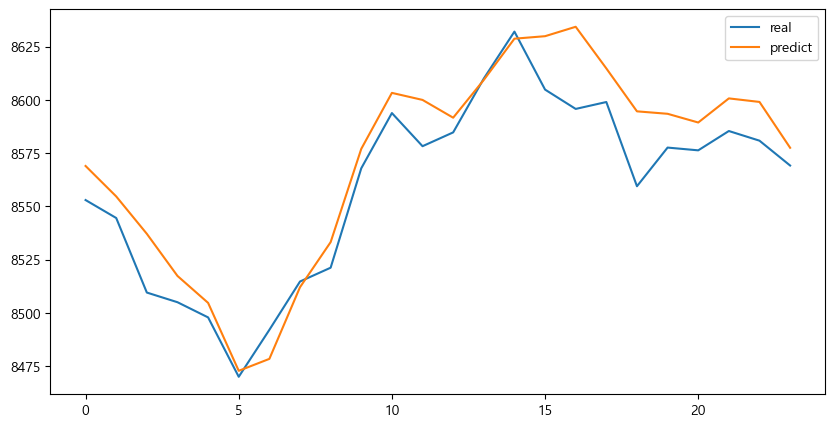

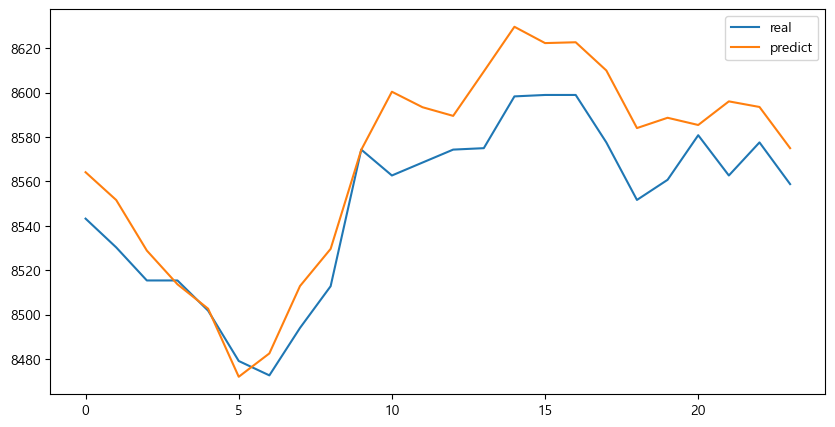

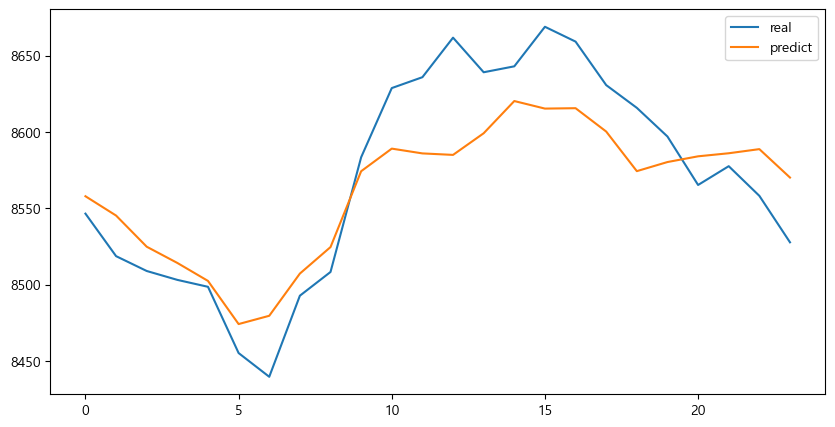

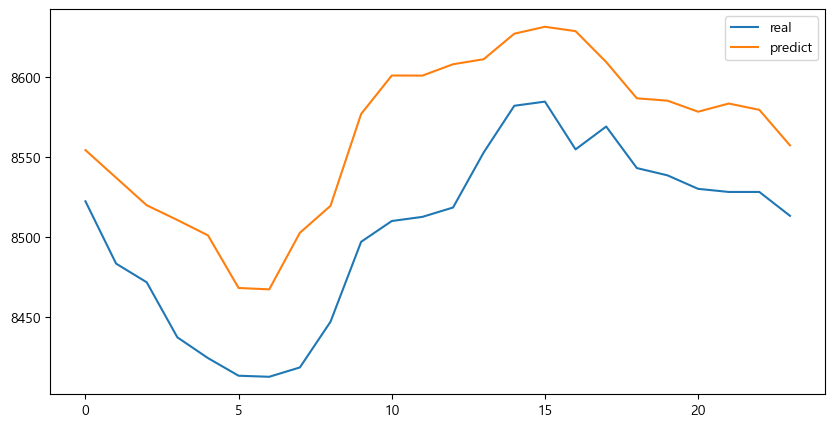

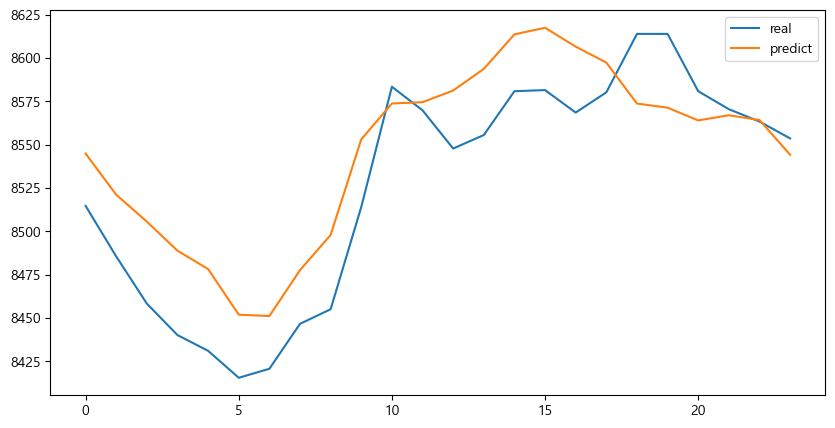

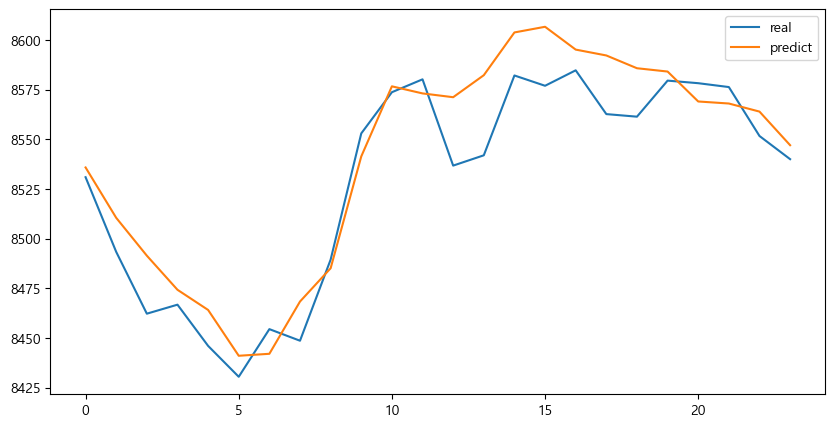

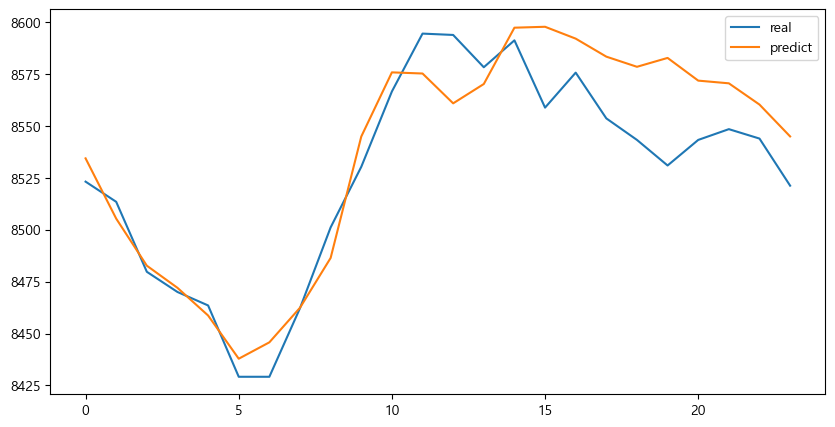

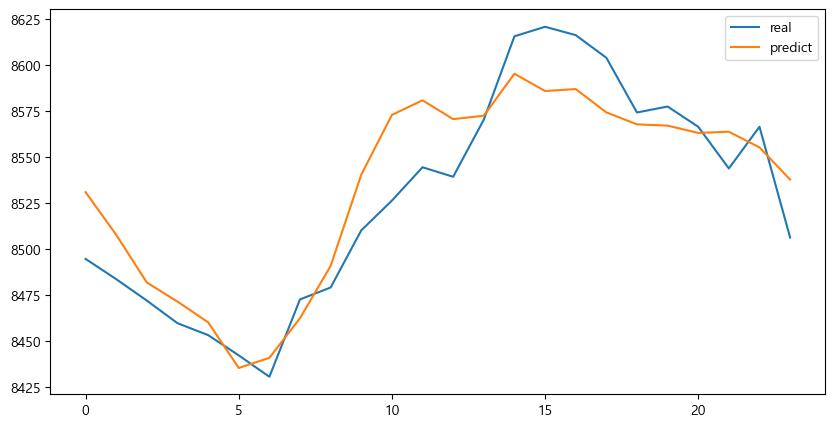

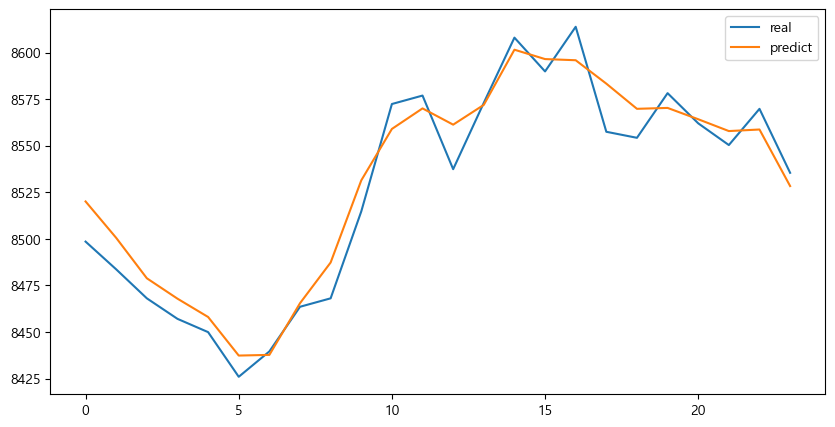

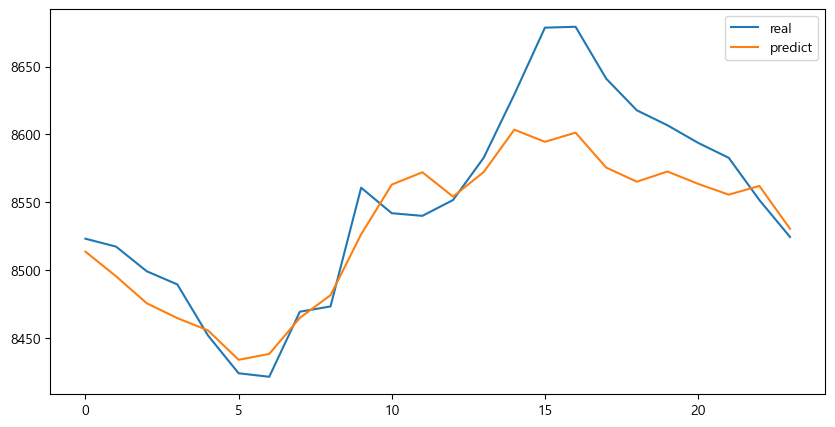

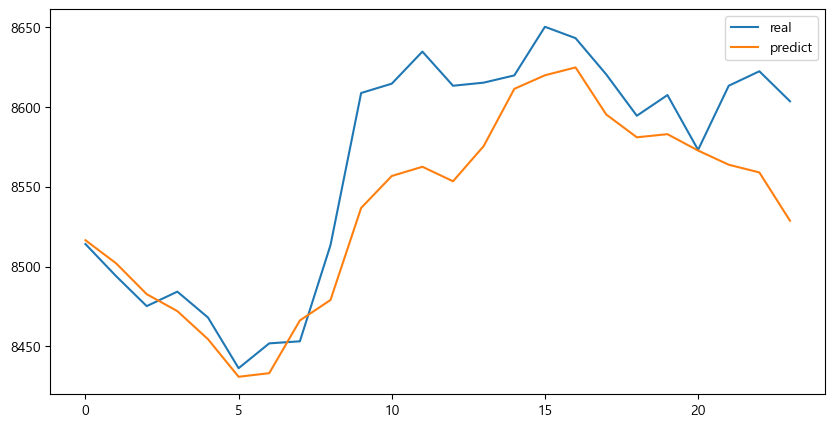

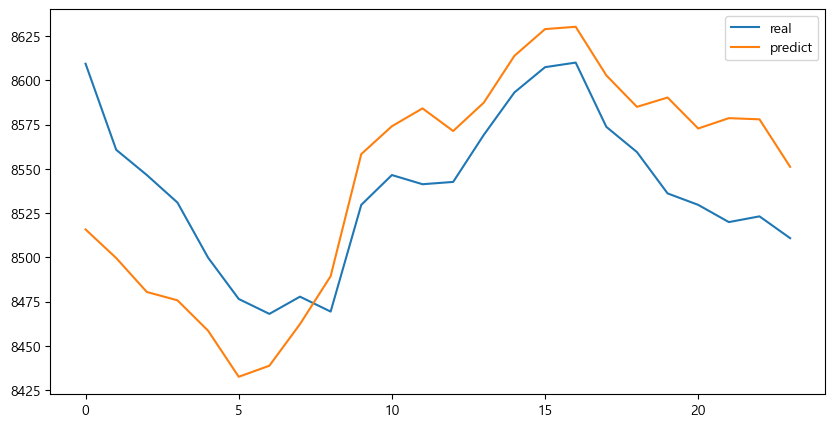

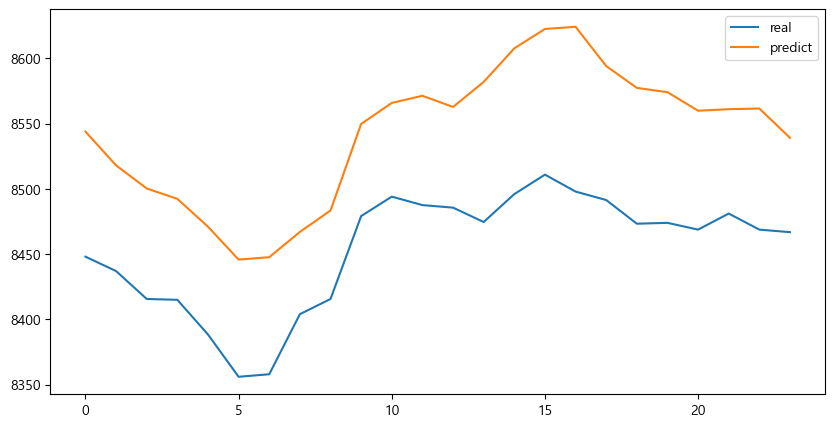

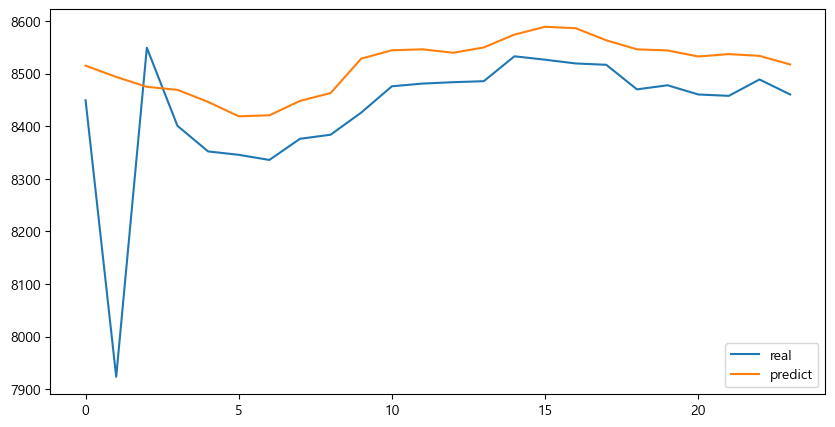

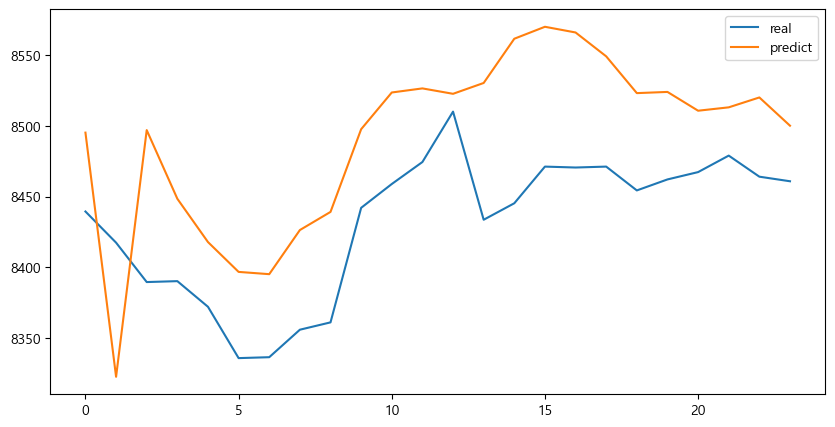

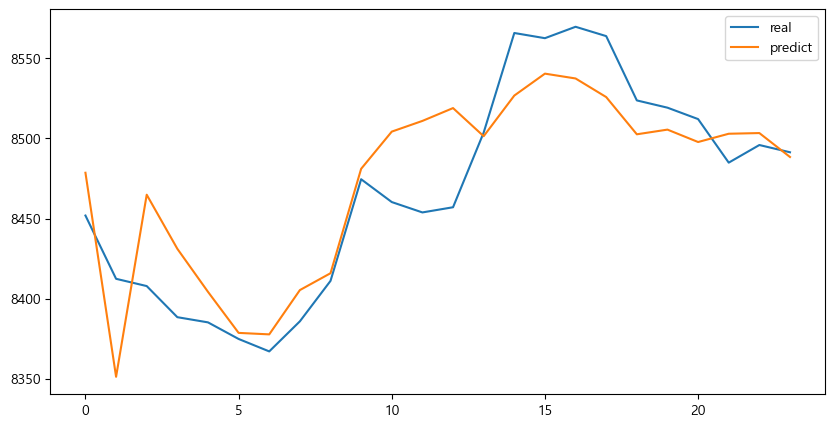

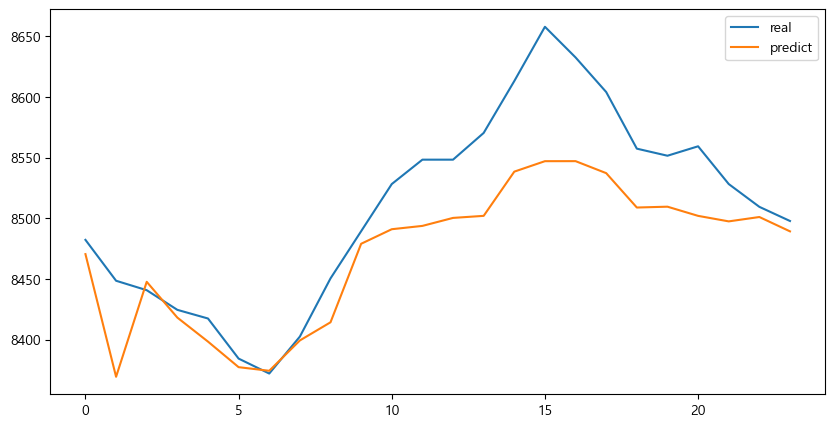

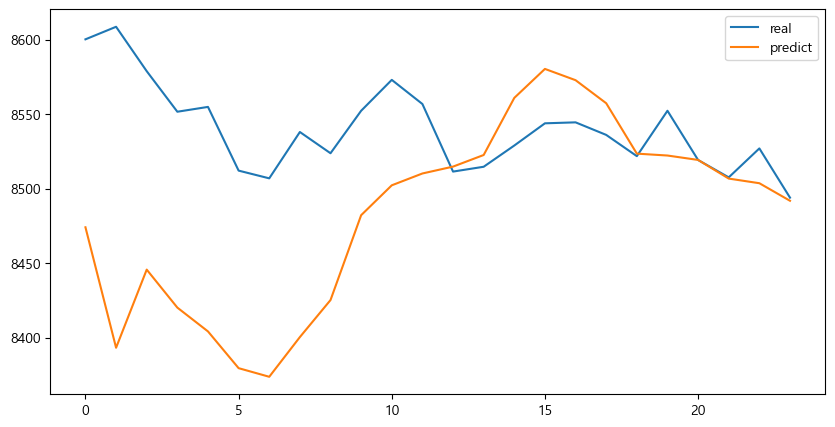

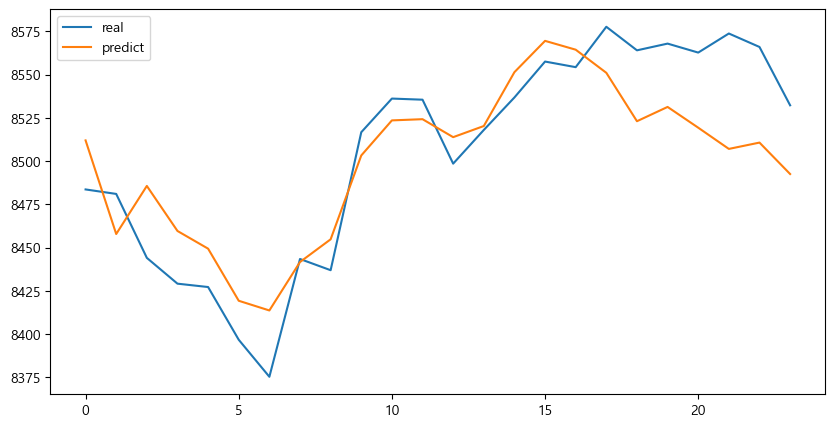

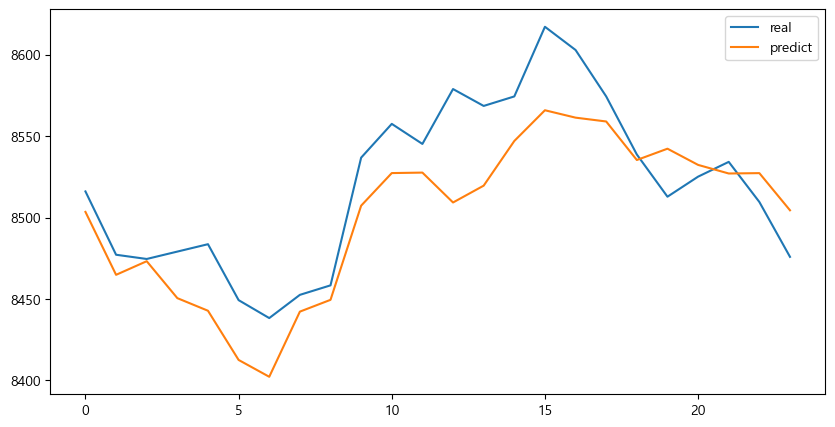

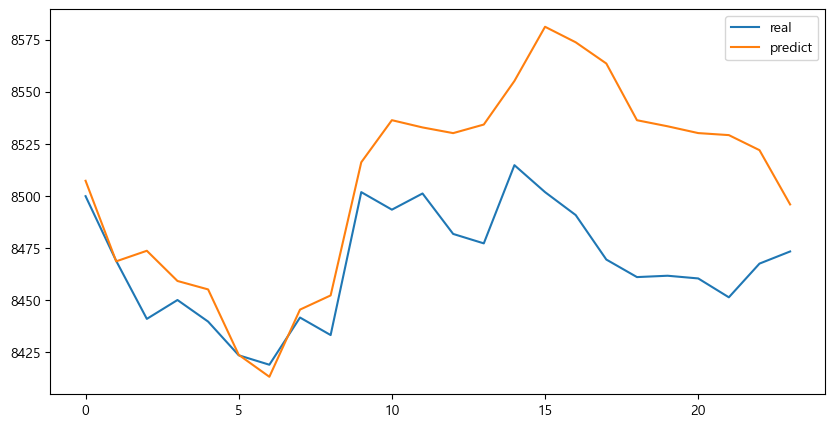

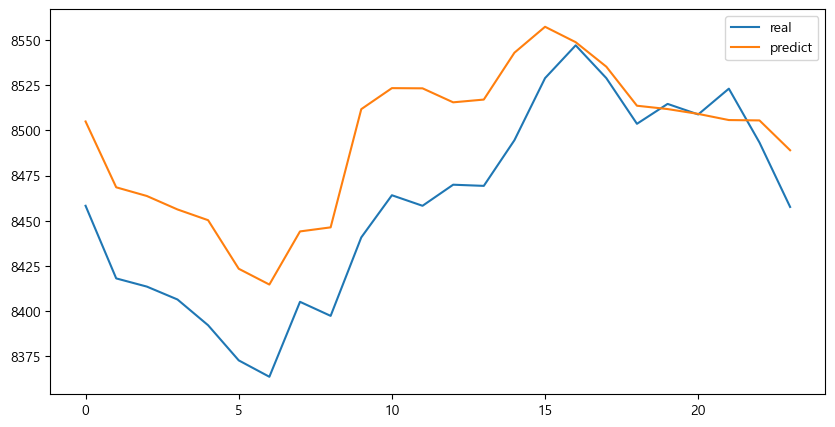

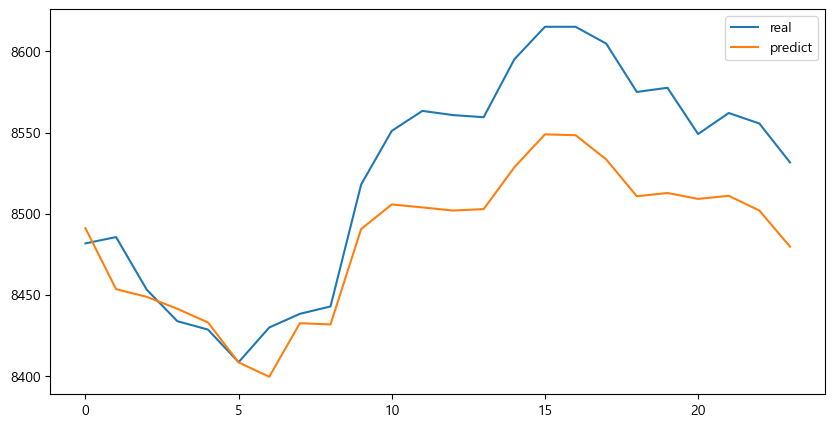

In [48]:
for i in range(40):
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(24), input_1.iloc[24*(i+1) : 24*(i+2), 1], label='real')
    plt.plot(np.arange(24), total_means[i], label='predict')
    plt.legend()
    plt.savefig('../energy_using_plot/plot_{}.png'.format(i))
